In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [2]:
!pip install nltk scikit-learn matplotlib scipy -q

In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>


False

In [49]:
from collections import Counter
from utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.stats import norm
from scipy.stats import entropy as calculate_entropy

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [378]:
import pickle


# Save to file in the current working directory
def save_model(model, pkl_filename = "pickle_model.pkl"):
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)

# Load from file
def load_model(pkl_filename = "pickle_model.pkl"):
    with open(pkl_filename, 'rb') as file:
        return pickle.load(file)

### load dataset

In [50]:
dataset = "newsgroup"

# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

all_docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
all_docs, old_labels, categories = all_docs.data, all_docs.target, all_docs.target_names

In [51]:
# dataset = "bbc"

# data = pd.read_csv('bbcsport.csv')

# all_docs = data["text"].to_list()
# old_labels = data["topic"].to_list()
# categories = classes = np.unique(data["topic"]).tolist()

### clean dataset

In [56]:
datasize = 40
min_document_length = 160
max_document_length = 256


index = -1
docs, labels, label_indices = [], [], []

sizes = [0]*len(categories)

with tqdm(total=len(categories)*datasize) as pbar:
    while sum(sizes) < len(categories)*datasize:
        index += 1
        label_index = old_labels[index]
            
        if sizes[label_index] == datasize:
            continue
        
        doc = all_docs[index]
        status, doc, word_count = clean_doc(doc, True)
        
        if not status:
            continue
            
        if min_document_length is not None and len(doc) < min_document_length:
            continue
            
        if max_document_length is not None and len(doc) > max_document_length:
            continue
        
        label_indices.append(label_index)
        labels.append(categories[label_index])
        
        docs.append(doc)
        sizes[label_index] += 1
        pbar.update(1)

labels = np.array(labels)
label_indices = np.array(label_indices)

In [57]:
doc_index = 3
print(f"Topic: {labels[doc_index]}\n{'='*50}\n{docs[doc_index][:512]}")

Topic: rec.autos
not to mention my friend s 54 citroen traction avant with the light switch and dimmer integrate in a single stalk off the steer column those dumb french be apparently copying the japanese before the german


In [58]:
print(sizes)
assert min(sizes) == max(sizes) == datasize

[40, 40, 40, 40]


### Split data

In [355]:
x_train, x_test, y_train, y_test = train_test_split(docs, labels, test_size =.3)

In [356]:
print(f"there are {len(docs)} total docs, {len(y_train)} train and {len(y_test)} test")

there are 160 total docs, 112 train and 48 test


### Initialize Vectorizer

In [357]:
# initialize the count vectorizer
vectorizer = CountVectorizer()

# fit it to dataset
vectorizer.fit(x_train)

vocabulary = np.array(vectorizer.get_feature_names())
print("word_count is", len(vocabulary))

word_count is 1440


### Prepare Datatset

In [412]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(x_train).toarray()
test_doc_vectors = vectorizer.transform(x_test).toarray()

wdf_train = pd.DataFrame(train_doc_vectors, columns=vocabulary)
wdf_test = pd.DataFrame(test_doc_vectors, columns=vocabulary)

# normalize
# wdf_train = wdf_train / wdf_train.max().max()
# wdf_test = wdf_test / wdf_test.max().max()

### Discover Topics


wdf_train_original kmeans, 4 classes, inertia = 3141.095404712671, best_inertia = 3091.661192058342
Counter({'rec.autos': 21, 'sci.space': 17, 'alt.atheism': 15, 'talk.politics.mideast': 9})
Counter({'talk.politics.mideast': 1, 'rec.autos': 1})
Counter({'talk.politics.mideast': 13, 'alt.atheism': 10, 'sci.space': 6, 'rec.autos': 4})
Counter({'rec.autos': 8, 'sci.space': 4, 'alt.atheism': 2, 'talk.politics.mideast': 1})

Counter({'rec.autos': 21, 'sci.space': 17, 'alt.atheism': 15, 'talk.politics.mideast': 9})
Counter({'talk.politics.mideast': 1, 'rec.autos': 1})
Counter({'talk.politics.mideast': 13, 'alt.atheism': 10, 'sci.space': 6, 'rec.autos': 4})
Counter({'rec.autos': 8, 'sci.space': 4, 'alt.atheism': 2, 'talk.politics.mideast': 1})



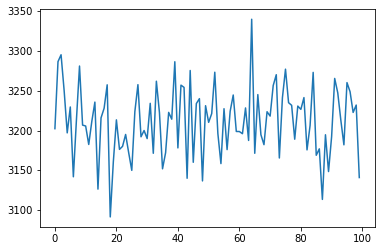

In [413]:
n_clusters = 4
random_state = 0
sample_ratio = .75
num_of_iterations = 100
max_num = len(y_train)

batch_size = int(sample_ratio * max_num)
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=random_state, batch_size=batch_size)

inertias = []
min_inertia = None

for _ in tqdm(range(num_of_iterations)):
    wx_batch, _, _, _ = train_test_split(wdf_train, y_train, train_size=sample_ratio)
    kmeans = kmeans.partial_fit(wx_batch)
    inertias.append(kmeans.inertia_)
    
    if min_inertia is None:
        min_inertia = kmeans.inertia_
        save_model(kmeans)
        
    elif kmeans.inertia_ < min_inertia:
        min_inertia = kmeans.inertia_
        save_model(kmeans)

best_kmeans = load_model()
print(f"wdf_train_original kmeans, {n_clusters} classes, inertia = {kmeans.inertia_}, best_inertia = {best_kmeans.inertia_}")

clusters = []
y_train_p = best_kmeans.predict(wdf_train)
y_train_prime = kmeans.predict(wdf_train)
y_test_prime = kmeans.predict(wdf_test)

for index in range(n_clusters):
    clusters.append(Counter(y_train[y_train_prime == index]))
    print(clusters[-1])
    
print()
for index in range(n_clusters):
    print(Counter(y_train[y_train_p == index]))
    
print()
plt.plot(list(range(num_of_iterations)), inertias)
plt.show()

In [414]:
y_train_prime = best_kmeans.predict(wdf_train)
y_test_prime = best_kmeans.predict(wdf_test)

## Word Topic Distr

In [415]:
wdt_test = wdf_test.copy()
wdt_train = wdf_train.copy()

wdt_train_prime = wdf_train.copy()
wdt_test_prime = wdf_test.copy()

wdt_test["__labels__"] = y_test
wdt_train["__labels__"] = y_train

wdt_train_prime["__labels__"] = y_train_prime
wdt_test_prime["__labels__"] = y_test_prime

topic_count = pd.DataFrame(Counter(y_train), index=[0]).T[0]
topic_count_prime = pd.DataFrame(Counter(y_train_prime), index=[0]).T[0]

word_topic_pr_distr = pd.DataFrame(data=0.0, columns=categories, index=vocabulary)
word_topic_pr_distr_prime = pd.DataFrame(data=0.0, columns=list(range(len(clusters))), index=vocabulary)

for index in tqdm(range(len(clusters))):
    cluster_index = index
    category = categories[index]
    
    pxy = wdf_train[wdt_train["__labels__"] == category].sum(0) / topic_count[category]
    pxy_prime = wdf_train_prime[wdt_train_prime["__labels__"] == cluster_index].sum(0) / topic_count_prime[cluster_index]
    
    word_topic_pr_distr[category] = pxy * (topic_count[category] / wdf_train.sum(0))
    word_topic_pr_distr_prime[cluster_index] = pxy_prime * (topic_count_prime[cluster_index] / wdf_train_prime.sum(0))

print(f"word_topic_pr_distr.shape = {word_topic_pr_distr.shape}, word_topic_pr_distr_prime.shape = {word_topic_pr_distr_prime.shape}")


word_topic_pr_distr.shape = (1440, 4), word_topic_pr_distr_prime.shape = (1440, 4)


In [416]:
score_train = score_train_prime = 0

for doc_index in tqdm(range(len(y_train))):
    doc_vector = wdf_train.loc[doc_index]
    doc_vector_prime = wdf_train_prime.loc[doc_index]
    
    _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)
    _, predicted_doc_topic_prime = infer_topic(range(len(clusters)), doc_vector_prime, word_topic_pr_distr_prime)

    mark = wdt_train.loc[doc_index]['__labels__'] == predicted_doc_topic
    mark_prime = wdt_train_prime.loc[doc_index]['__labels__'] == predicted_doc_topic_prime
    
    score_train += mark
    score_train_prime += mark_prime

train_accuracy = score_train / len(y_train)
train_accuracy_prime = score_train_prime / len(y_train_prime)

print(f"train_accuracy = {train_accuracy: .4f}, train_accuracy_prime = {train_accuracy_prime: .4f}")


train_accuracy =  1.0000, train_accuracy_prime =  0.5625


In [417]:
# for i, j in zip(y_train_prime, y_train):
#     print(j, clusters[i])

In [418]:
score_test = score_test_prime = 0

for doc_index in tqdm(range(len(y_test))):
    doc_vector = wdf_test.loc[doc_index]
    doc_vector_prime = wdf_test_prime.loc[doc_index]
    
    _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)
    _, predicted_doc_topic_prime = infer_topic(range(len(clusters)), doc_vector_prime, word_topic_pr_distr_prime)

    mark = wdt_test.loc[doc_index]['__labels__'] == predicted_doc_topic
    mark_prime = wdt_test_prime.loc[doc_index]['__labels__'] == predicted_doc_topic_prime
    
    score_test += mark
    score_test_prime += mark_prime

test_accuracy = score_test / len(y_test)
test_accuracy_prime = score_test_prime / len(y_test_prime)

print(f"test_accuracy = {test_accuracy: .4f}, test_accuracy_prime = {test_accuracy_prime: .4f}")


test_accuracy =  0.5000, test_accuracy_prime =  0.5833
